In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

###

from lazypredict.Supervised import LazyRegressor
import lazypredict.Supervised

import sklearn
import xgboost
import lightgbm

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'pandas'

In [51]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,day_sin,day_cos,hour_cos,hour_sin
0,None,288.28,0.00,0.00,40,Clouds,scattered clouds,5545,-1.00,0.04,-0.71,0.71
1,None,289.36,0.00,0.00,75,Clouds,broken clouds,4516,-1.00,0.04,-0.87,0.50
2,None,289.58,0.00,0.00,90,Clouds,overcast clouds,4767,-1.00,0.04,-0.97,0.26
3,None,290.13,0.00,0.00,90,Clouds,overcast clouds,5026,-1.00,0.04,-1.00,0.00
4,None,291.14,0.00,0.00,75,Clouds,broken clouds,4918,-1.00,0.04,-0.97,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.00,0.00,75,Clouds,broken clouds,3543,-1.00,-0.01,0.26,-0.97
48200,None,282.76,0.00,0.00,90,Clouds,overcast clouds,2781,-1.00,-0.01,0.50,-0.87
48201,None,282.73,0.00,0.00,90,Thunderstorm,proximity thunderstorm,2159,-1.00,-0.01,0.71,-0.71
48202,None,282.09,0.00,0.00,90,Clouds,overcast clouds,1450,-1.00,-0.01,0.87,-0.50


In [33]:
df = pd.read_csv('UCI_datasets/Metro_Interstate_Traffic_Volume.csv')

In [34]:
#drop rows with nan
#drop cols with nan
#encode dates in cos/sin
#encode hour in cos sin
df.shape

(48204, 9)

In [35]:
df.isna().sum().tail(50) #> 50

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [36]:
def one_hot_encode(df, cols):
    # Get one hot encoding of columns B
    for c in cols:
        one_hot = pd.get_dummies(df[c])
        # Drop column B as it is now encoded
        df = df.drop(c,axis = 1)
        # Join the encoded df
        df = df.join(one_hot)
    return df

In [37]:
#prepare cos sin of day
format_day =  '%Y-%m-%d %H:%M:%S'
col = 'date_time'
dates = [datetime.strptime(df[col][i], format_day) for i in range(df.shape[0])]
days = [d.day for d in dates]
months = [d.month for d in dates]
day_of_year = [d.timetuple().tm_yday for d in dates]
day_of_year_cos = [np.cos(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]
day_of_year_sin = [np.sin(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]


df['day_sin'] = [np.sin(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]
df['day_cos'] = [np.cos(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]

hours = [d.hour for d in dates]

df['hour_cos'] = [np.cos(2 * np.pi * hours[i]/24) for i in range(len(day_of_year))]
df['hour_sin'] = [np.sin(2 * np.pi * hours[i]/24) for i in range(len(day_of_year))]

df = df.drop(col, axis = 1)

In [38]:
df2 = one_hot_encode(df, ['weather_main', 'weather_description'])


In [39]:
df2 = df2.drop('holiday', axis=1)

In [40]:
df2

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day_sin,day_cos,hour_cos,hour_sin,Clear,...,sleet,smoke,snow,thunderstorm,thunderstorm with drizzle,thunderstorm with heavy rain,thunderstorm with light drizzle,thunderstorm with light rain,thunderstorm with rain,very heavy rain
0,288.28,0.00,0.00,40,5545,-1.00,0.04,-0.71,0.71,0,...,0,0,0,0,0,0,0,0,0,0
1,289.36,0.00,0.00,75,4516,-1.00,0.04,-0.87,0.50,0,...,0,0,0,0,0,0,0,0,0,0
2,289.58,0.00,0.00,90,4767,-1.00,0.04,-0.97,0.26,0,...,0,0,0,0,0,0,0,0,0,0
3,290.13,0.00,0.00,90,5026,-1.00,0.04,-1.00,0.00,0,...,0,0,0,0,0,0,0,0,0,0
4,291.14,0.00,0.00,75,4918,-1.00,0.04,-0.97,-0.26,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,283.45,0.00,0.00,75,3543,-1.00,-0.01,0.26,-0.97,0,...,0,0,0,0,0,0,0,0,0,0
48200,282.76,0.00,0.00,90,2781,-1.00,-0.01,0.50,-0.87,0,...,0,0,0,0,0,0,0,0,0,0
48201,282.73,0.00,0.00,90,2159,-1.00,-0.01,0.71,-0.71,0,...,0,0,0,0,0,0,0,0,0,0
48202,282.09,0.00,0.00,90,1450,-1.00,-0.01,0.87,-0.50,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
returns = np.zeros(len(df))
returns[1:] = (np.array(df['Close'][1:]) - np.array(df['Close'][:-1]))/np.array(df['Close'][:-1])
df['Returns'] = returns

closes_diff = np.zeros(len(df))
closes_diff[1:] = np.array(df['Close'][1:]) - np.array(df['Close'][:-1])
df['Closes_Diff'] = closes_diff

In [78]:
#drop rows 1-50
df = df.drop(index = [i for i in range(50)])

#drop columns with too many NaNs
perc = 5.0 # Like N %
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1, 
                thresh=min_count)

#interpolate missing values
df = df.interpolate()

In [79]:
#drop useless columns
df = df.drop(columns = ['Date', 'Name'])

In [85]:
df

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU,day_sin,day_cos,Returns
50,7426.700195,0.049389,0.010303,-0.001615,0.001307,0.003490,1.819027,4.074148,6.482093,5.893761,...,0.80,-0.62,-0.21,-0.62,1.83,2.11,1.50,0.961130,0.276097,0.010303
51,7474.129883,0.135803,0.006386,0.010303,-0.001615,0.001307,1.998725,4.319392,6.307506,6.239050,...,0.54,-0.09,-0.19,-0.14,1.74,0.40,-0.06,0.965740,0.259512,0.006386
52,7443.569824,-0.146819,-0.004089,0.006386,0.010303,-0.001615,1.228432,3.771049,6.132782,5.129526,...,0.02,0.30,0.74,0.73,-1.31,-0.69,0.08,0.970064,0.242850,-0.004089
53,7386.850098,0.230936,-0.007620,-0.004089,0.006386,0.010303,0.325961,1.310327,5.000825,4.286169,...,0.60,0.38,0.66,0.62,-0.95,-2.36,-1.63,0.974100,0.226116,-0.007620
54,7419.020020,-0.182397,0.004355,-0.007620,-0.004089,0.006386,0.925866,1.734518,4.482203,4.810183,...,-0.93,-0.37,-0.11,-0.09,0.49,-0.12,-0.47,0.984474,0.175531,0.004355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,12339.660156,-0.017375,-0.003638,0.001089,-0.002393,0.002252,-0.269134,-0.103377,-0.328426,0.007456,...,-0.27,-0.61,-0.44,-0.45,0.53,-0.26,0.32,-0.780296,0.625411,-0.003638
1980,12322.599609,-0.089962,-0.001383,-0.003638,0.001089,-0.002393,-0.407821,-0.354428,-0.868185,-0.238021,...,-0.17,0.18,-0.07,-0.05,0.70,-0.71,-0.80,-0.769415,0.638749,-0.001383
1981,12316.820313,-0.024084,-0.000469,-0.001383,-0.003638,0.001089,-0.678251,-0.021506,-0.545844,-0.345476,...,0.10,0.06,0.12,0.11,-1.85,0.83,0.16,-0.735417,0.677615,-0.000469
1982,12280.110352,0.070184,-0.002980,-0.000469,-0.001383,-0.003638,-0.736705,-0.493472,-1.006691,-0.565664,...,-0.15,-0.70,-0.71,-0.70,1.00,0.01,0.24,-0.723644,0.690173,-0.002980


In [24]:
def prepare_x_y(df, T_past, T_future, target_name):
    n, p = df.shape
    X = np.zeros((n-T_past-T_future+1, T_past*p))
    y = df[target_name][T_past+T_future-1:]
    print("Data shape:", X.shape)
    for t in range(T_past):
        X[:,t*p:(t+1)*p] = np.array(df[T_past-t-1:-T_future-t])
    return X,y

In [42]:
X, y = prepare_x_y(df2, 12, 1, 'traffic_volume')

Data shape: (48192, 696)


In [53]:
X, y = prepare_x_y(df2, 6, 1, 'traffic_volume')

Data shape: (48198, 348)


In [43]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.5, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=False)

# Lazy ensembles

In [64]:
l = [('AdaBoostRegressor', sklearn.ensemble._weight_boosting.AdaBoostRegressor),
 ('BaggingRegressor', sklearn.ensemble._bagging.BaggingRegressor),
 ('BayesianRidge', sklearn.linear_model._bayes.BayesianRidge),
 ('DecisionTreeRegressor', sklearn.tree._classes.DecisionTreeRegressor),
 ('DummyRegressor', sklearn.dummy.DummyRegressor),
 ('ElasticNet', sklearn.linear_model._coordinate_descent.ElasticNet),
 ('ElasticNetCV', sklearn.linear_model._coordinate_descent.ElasticNetCV),
 ('ExtraTreeRegressor', sklearn.tree._classes.ExtraTreeRegressor),
 ('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('GammaRegressor', sklearn.linear_model._glm.glm.GammaRegressor),
 ('GeneralizedLinearRegressor',
  sklearn.linear_model._glm.glm.GeneralizedLinearRegressor),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('HistGradientBoostingRegressor',
  sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor),
 ('HuberRegressor', sklearn.linear_model._huber.HuberRegressor),
 ('KernelRidge', sklearn.kernel_ridge.KernelRidge),
 #('Lars', sklearn.linear_model._least_angle.Lars),
 ('LarsCV', sklearn.linear_model._least_angle.LarsCV),
 ('Lasso', sklearn.linear_model._coordinate_descent.Lasso),
 ('LassoCV', sklearn.linear_model._coordinate_descent.LassoCV),
 ('LassoLars', sklearn.linear_model._least_angle.LassoLars),
 ('LassoLarsCV', sklearn.linear_model._least_angle.LassoLarsCV),
 ('LassoLarsIC', sklearn.linear_model._least_angle.LassoLarsIC),
 #('LinearRegression', sklearn.linear_model._base.LinearRegression),
 ('LinearSVR', sklearn.svm._classes.LinearSVR),
 #('MLPRegressor', sklearn.neural_network._multilayer_perceptron.MLPRegressor),
 ('OrthogonalMatchingPursuit',
  sklearn.linear_model._omp.OrthogonalMatchingPursuit),
 ('OrthogonalMatchingPursuitCV',
  sklearn.linear_model._omp.OrthogonalMatchingPursuitCV),
 #('PassiveAggressiveRegressor',
  #sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor),
 ('PoissonRegressor', sklearn.linear_model._glm.glm.PoissonRegressor),
 #('RANSACRegressor', sklearn.linear_model._ransac.RANSACRegressor),
 ('Ridge', sklearn.linear_model._ridge.Ridge),
 ('RidgeCV', sklearn.linear_model._ridge.RidgeCV),
 #('SGDRegressor', sklearn.linear_model._stochastic_gradient.SGDRegressor),
 #('TransformedTargetRegressor',
  #sklearn.compose._target.TransformedTargetRegressor),
 ('TweedieRegressor', sklearn.linear_model._glm.glm.TweedieRegressor),
 ('XGBRegressor', xgboost.sklearn.XGBRegressor),
 ('LGBMRegressor', lightgbm.sklearn.LGBMRegressor)]

In [66]:
lazypredict.Supervised.REGRESSORS = l

In [67]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_test_val_scaled = scaler.transform(X_test_val)


scaler_y = StandardScaler()
scaler_y.fit(np.array(y_train).reshape(-1,1))
y_train_scaled = scaler_y.transform(np.array(y_train).reshape(-1,1)).reshape(-1)
y_val_scaled = scaler_y.transform(np.array(y_val).reshape(-1,1)).reshape(-1)
y_test_scaled = scaler_y.transform(np.array(y_test).reshape(-1,1)).reshape(-1)
y_test_val_scaled = scaler_y.transform(np.array(y_test_val).reshape(-1,1)).reshape(-1)

(array([4098., 2550., 1398., 2446., 2362., 1959., 3666., 2945., 2111.,
         564.]),
 array([-1.62249648, -1.26211081, -0.90172514, -0.54133946, -0.18095379,
         0.17943188,  0.53981755,  0.90020322,  1.26058889,  1.62097457,
         1.98136024]),
 <BarContainer object of 10 artists>)

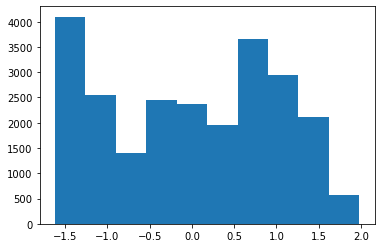

In [68]:
plt.hist(y_train_scaled)

In [70]:
clf = LazyRegressor(predictions=True)
models, predictions = clf.fit(X_train_scaled, X_test_val_scaled, y_train_scaled, y_test_val_scaled)
print(models)

100%|██████████| 30/30 [03:51<00:00,  7.72s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.97       0.97  0.18        1.41
HistGradientBoostingRegressor                0.96       0.97  0.18        7.84
ExtraTreesRegressor                          0.96       0.96  0.19       68.57
XGBRegressor                                 0.96       0.96  0.19        2.17
GradientBoostingRegressor                    0.96       0.96  0.20       25.54
BaggingRegressor                             0.96       0.96  0.20        9.80
ExtraTreeRegressor                           0.92       0.92  0.28        1.20
DecisionTreeRegressor                        0.91       0.91  0.28        1.76
LassoLarsCV                                  0.89       0.89  0.32        1.95
LassoLarsIC                                  0.89       0.89  0.33        0.65
LarsCV                                       0.88   

In [71]:
for i in range(predictions.shape[1]):
    print(mean_absolute_error(y_test_val_scaled, np.array(predictions)[:,i]))
print("Baseline:", mean_absolute_error(y_test_val_scaled, np.mean(y_train_scaled)*np.ones(len(y_test_val_scaled))))

0.4694396829064609
0.12676449403409065
0.2129932282384239
0.1649762403922015
0.8527793671494751
0.6096146932416101
0.2075205502463192
0.16522019934162632
0.11704310442862112
0.35857656222772516
0.13600355194295768
0.1196971319941346
0.18829114828521046
0.21248525825319625
0.2377235415194594
0.8527793671494751
0.20649058576835588
0.8527793671494751
0.2058937796626709
0.20733222777603208
0.22850543212900787
0.20700566394134365
0.20703375082112105
0.21248525825314815
0.2126871580280134
0.35857656222772516
0.12470590498349296
0.11865893528956903
Baseline: 0.8527793671494751


In [78]:
predictions.to_csv('traffic_predictions_test_val.csv')
pd.DataFrame(y_test_val_scaled, columns = ['target']).to_csv('traffic_test_val_scaled.csv')

In [77]:
pd.DataFrame(y_test_val_scaled, columns = ['target'])

,target
0,-0.84
1,-0.37
2,0.20
3,0.54
4,0.70
...,...
24094,0.14
24095,-0.24
24096,-0.55
24097,-0.90


In [52]:
print("Baseline:", mean_absolute_error(y_val_scaled, np.mean(y_train_scaled)*np.ones(len(y_val_scaled))))

Baseline: 0.8746007542379874


In [ ]:
np.min()

In [73]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train_scaled, y_train_scaled)
preds = xgb.predict(X_test_val_scaled)
print(mean_absolute_error(y_test_val_scaled, preds))

0.12470590498349296


In [ ]:
predictions.to_csv("predictions_test_sin.csv")